# 피벗테이블 (Pivot Tables)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

print("pandas ver : ",pd.__version__)
print("numpy ver : ",np.__version__)
print("seaborn : ",sns.__version__)

import pandas as pd
import numpy as np

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

pandas ver :  0.24.2
numpy ver :  1.16.4
seaborn :  0.9.0


- Seaborn 데이터세트 로딩 : 타이타닉 승객 데이터 사용

In [2]:
titanic = sns.load_dataset('titanic')
print(type(titanic))
print(titanic.shape)

<class 'pandas.core.frame.DataFrame'>
(891, 15)


In [3]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


### [GroupBy 활용한 통계법]

- **성별에 따른 생존율 (Groupby 사용)**

In [4]:
group_result1 = titanic.groupby(by='sex')
print(type(group_result1))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


- DataFrame groupby
  - `DataFrame.groupby(self, by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, squeeze=False, observed=False, **kwargs)`
    - by: mapping, function, label, or list of labels

In [5]:
# 성별에 따른 생존율
group_result1[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


- **성별과 좌석 등급에 따른 생존율**

In [6]:
group_result2 = titanic.groupby(by=['sex', 'class'])
print(type(group_result2))

<class 'pandas.core.groupby.generic.DataFrameGroupBy'>


In [7]:
# aggregate 집계
print(type(group_result2['survived'].aggregate('mean')))
print(group_result2['survived'].aggregate(np.mean))

<class 'pandas.core.series.Series'>
sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64


In [8]:
print(type(group_result2['survived'].aggregate(np.mean).unstack()))
group_result2['survived'].aggregate(np.mean).unstack()

<class 'pandas.core.frame.DataFrame'>


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


### [피벗 테이블 구문]

###### 기본 사용법 
- **Pivot table**
  - `DataFrame.pivot_table(self, values=None, index=None, columns=None, aggfunc='mean', fill_value=None, margins=False, dropna=True, margins_nme='All', observed=False)`

In [9]:
# pivot_table을 이용한 통계
titanic.pivot_table('survived', index='sex', columns='class')

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


- **pivot_table** 이 GroupBy 를 사용한 코드보다 훨씬 읽기 쉬움

In [10]:
# GroupBy를 이용한 통계
group_result2['survived'].aggregate(np.mean).unstack()

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


###### 다단계 피봇 테이블

- **pandas.cut**
  - `pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False, duplicates='raise')`
    - x : array-like The input array to be binned. Must be 1-dimensional.
    - bins : int, sequence of scalars, or IntervalIndex The criteria to bin by.
      - *int* : Defines the number of equal-width bins in the range of x. The range of x is extended by .1% on each side to include the minimum and maximum values of x.
      - *sequence of scalars* : Defines the bin edges allowing for non-uniform width. No extension of the range of x is done.
      - *IntervalIndex* : Defines the exact bins to be used. Note that IntervalIndex for bins must be non-overlapping.

In [11]:
titanic['age'].head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: age, dtype: float64

In [12]:
# 0~18, 18~80 구간으로 분류
age = pd.cut(titanic['age'] , [0, 18, 80])

- 생존자중 좌석 등급별 성별 나이구간의 비율

In [13]:
titanic.pivot_table('survived', index=['sex', age], columns='class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

In [14]:
fare = pd.qcut(titanic['fare'], 2)
titanic.pivot_table('survived', ['sex', age], [fare, 'class'])

fare            (-0.001, 14.454]                     (14.454, 512.329]  \
class                      First    Second     Third             First   
sex    age                                                               
female (0, 18]               NaN  1.000000  0.714286          0.909091   
       (18, 80]              NaN  0.880000  0.444444          0.972973   
male   (0, 18]               NaN  0.000000  0.260870          0.800000   
       (18, 80]              0.0  0.098039  0.125000          0.391304   

fare                                 
class              Second     Third  
sex    age                           
female (0, 18]   1.000000  0.318182  
       (18, 80]  0.914286  0.391304  
male   (0, 18]   0.818182  0.178571  
       (18, 80]  0.030303  0.192308

### [ 출생률 데이터 예제]

In [15]:
births = pd.read_csv('./data/births.csv')
print(type(births))

<class 'pandas.core.frame.DataFrame'>


In [16]:
display('births.head()','births.tail()')

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548
,year,month,day,gender,births
15542,2008,10,NaN,M,183219
15543,2008,11,NaN,F,158939
15544,2008,11,NaN,M,165468
15545,2008,12,NaN,F,173215


In [17]:
births.columns

Index(['year', 'month', 'day', 'gender', 'births'], dtype='object')

- 출생 연대 계산 하여 컬럼으로 추가 

In [18]:
births['decade'] = (births['year'] // 10) * 10

In [19]:
display('births.head()','births.tail()')

,year,month,day,gender,births,decade
0,1969,1,1.0,F,4046,1960
1,1969,1,1.0,M,4440,1960
2,1969,1,2.0,F,4454,1960
3,1969,1,2.0,M,4548,1960
4,1969,1,3.0,F,4548,1960
,year,month,day,gender,births,decade
15542,2008,10,NaN,M,183219,2000
15543,2008,11,NaN,F,158939,2000
15544,2008,11,NaN,M,165468,2000
15545,2008,12,NaN,F,173215,2000


- 연대별 남녀 출생 수

In [20]:
births.pivot_table('births', index='decade', columns=['gender'])

gender,F,M
decade,,
1960,4566.755208,4808.781250
1970,4267.403569,4497.386393
1980,5460.886072,5740.886635
1990,162328.783333,170171.275000
2000,168789.898148,176911.370370


In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
sns.set()

Text(0, 0.5, 'total births per year')

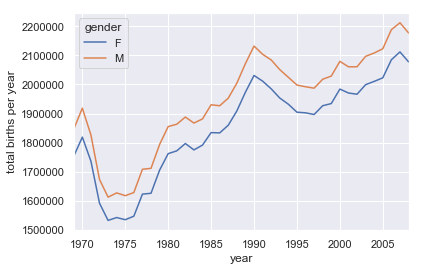

In [22]:
births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year')